In [1]:
## imports
import os
import sys
from __future__ import print_function
from pathlib import Path
import nilmtk
from matplotlib import rcParams
import matplotlib.pyplot as plt
%matplotlib inline

## imports for the function 
import pandas as pd
import numpy as np
from typing import Union, Tuple, Dict
from nilmtk.utils import print_dict  
import json
from skimage.measure import block_reduce
from pprint import pprint

## path for load
sys.path.append(os.path.dirname(os.getcwd()))

## import for the load_data python
from src.unetnilm.data_proc import load_data
from src.stats.Statistical_analysis import extract_states, state_plot

In [2]:
## dataset loading
from src.utils import paths_manager as pathsman

## Variable declaration for dataset
BUILDING = 1

## Dataset initialization
dataset = nilmtk.DataSet(pathsman.UKDALE_H5_PATH)
dataset.set_window(start="2015-01-01", end="2015-03-30")

In [3]:
#dataset.buildings[BUILDING].elec

In [4]:
# print(dataset.buildings[BUILDING].elec["fridge"])
# print(dataset.buildings[BUILDING].elec["washer dryer"])
# print(dataset.buildings[BUILDING].elec["toasted sandwich maker"])
# print(dataset.buildings[BUILDING].elec["dish washer"])
# print(dataset.buildings[BUILDING].elec["microwave"])

In [5]:
# dataset.buildings[BUILDING].elec["kettle"].plot()
# dataset.buildings[BUILDING].elec["toasted sandwich maker"].plot()
# dataset.buildings[BUILDING].elec["food processor"].plot()

In [6]:
# ## Initial/raw data plot
# dataset.buildings[BUILDING].elec["fridge"].plot()
# dataset.buildings[BUILDING].elec["washer dryer"].plot()
# dataset.buildings[BUILDING].elec["kettle"].plot()
# dataset.buildings[BUILDING].elec["dish washer"].plot()
# dataset.buildings[BUILDING].elec["microwave"].plot()

In [7]:
# dataset.buildings[BUILDING].elec["fridge"].power_series_all_data().plot()
# dataset.buildings[BUILDING].elec["washer dryer"].power_series_all_data().plot()
# dataset.buildings[BUILDING].elec["kettle"].power_series_all_data().plot()
# dataset.buildings[BUILDING].elec["dish washer"].power_series_all_data().plot()
# dataset.buildings[BUILDING].elec["microwave"].power_series_all_data().plot()

In [8]:
## Helper Functions

def binarization(data,threshold):
    """[summary]
    
    Arguments:
        data {[type]} -- [description]
        threshold {[type]} -- [description]
    
    Returns:
        [type] -- [description]
    """
    state = np.where(data>= threshold,1,0).astype(int)
    return state

def get_percentile(data,p=50):
    """[summary]
    
    Arguments:
        data {[type]} -- [description]
        quantile {[type]} -- [description]
    
    Returns:
        [type] -- [description]
    """
    return np.percentile(data, p, axis=1, interpolation="nearest")

def generate_sequences(sequence_length, data):
    sequence_length = sequence_length - 1 if sequence_length% 2==0 else sequence_length
    units_to_pad = sequence_length // 2
    new_mains = np.pad(data, (units_to_pad,units_to_pad),'constant',constant_values=(0,0))
    new_mains = np.array([new_mains[i:i + sequence_length] for i in range(len(new_mains) - sequence_length+1)])
    return new_mains

def quantile_filter(sequence_length, data, p=50):
    new_mains = generate_sequences(sequence_length, data)
    new_mains = get_percentile(new_mains, p)
    return new_mains

In [9]:
## Appliance Dictionary Declaration
building = 1
appliance = {
    "fridge" : {
        "window" : 50,
        "mean" : float(dataset.buildings[building].elec["fridge"].power_series_all_data().mean()),
        "std" : float(dataset.buildings[building].elec["fridge"].power_series_all_data().std()),
        "min" : float(dataset.buildings[building].elec["fridge"].power_series_all_data().min()),
        "max" : float(dataset.buildings[building].elec["fridge"].power_series_all_data().max())
    },
    "washer dryer" : {
        "window" : 50,
        "mean" : float(dataset.buildings[building].elec["washer dryer"].power_series_all_data().mean()),
        "std" : float(dataset.buildings[building].elec["washer dryer"].power_series_all_data().std()),
        "min" : float(dataset.buildings[building].elec["washer dryer"].power_series_all_data().min()),
        "max" : float(dataset.buildings[building].elec["washer dryer"].power_series_all_data().max())
    },
    "kettle" : {
        "window" : 10,
        "mean" : float(dataset.buildings[building].elec["kettle"].power_series_all_data().mean()),
        "std" : float(dataset.buildings[building].elec["kettle"].power_series_all_data().std()),
        "min" : float(dataset.buildings[building].elec["kettle"].power_series_all_data().min()),
        "max" : float(dataset.buildings[building].elec["kettle"].power_series_all_data().max())
    },
    "dish washer" : {
        "window" : 50,
        "mean" : float(dataset.buildings[building].elec["dish washer"].power_series_all_data().mean()),
        "std" : float(dataset.buildings[building].elec["dish washer"].power_series_all_data().std()),
        "min" : float(dataset.buildings[building].elec["dish washer"].power_series_all_data().min()),
        "max" : float(dataset.buildings[building].elec["dish washer"].power_series_all_data().max())
    },
    "microwave" : {
        "window" : 10,
        "mean" : float(dataset.buildings[building].elec["microwave"].power_series_all_data().mean()),
        "std" : float(dataset.buildings[building].elec["microwave"].power_series_all_data().std()),
        "min" : float(dataset.buildings[building].elec["microwave"].power_series_all_data().min()),
        "max" : float(dataset.buildings[building].elec["microwave"].power_series_all_data().max())
    }
}

In [10]:
power_elec = dataset.buildings[building].elec

indices = [power_elec[app].power_series_all_data().index for app in appliance.keys()]
sorted_indices = sorted(indices, key=len)

main_index = sorted_indices[0]
reduced_power_series_list = []

In [11]:
targets = []
states = [] 

for app in appliance.keys():
    power_series = power_elec[app].power_series_all_data()
    reduced_power_series = power_series[power_series.index.get_indexer(main_index, method="nearest")]
    reduced_power_series_list.append(reduced_power_series)
    meter = quantile_filter(appliance[app]["window"], reduced_power_series, p=50)
    state = binarization(meter, power_elec[app].on_power_threshold())
    targets.append(meter)
    states.append(state)

C:\Users\IMercan2\AppData\Local\Temp\ipykernel_34364\1755866677.py:26: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  return np.percentile(data, p, axis=1, interpolation="nearest")
C:\Users\IMercan2\AppData\Local\Temp\ipykernel_34364\1755866677.py:26: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  return np.percentile(data, p, axis=1, interpolation="nearest")
C:\Users\IMercan2\AppData\Local\Temp\ipykernel_34364\1755866677.py:26: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest',

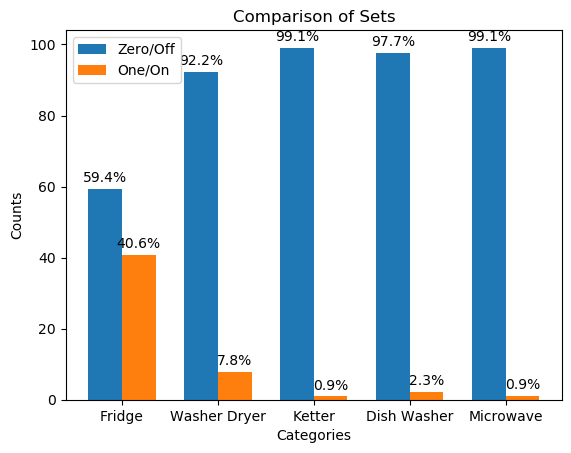

In [12]:
zero, one = extract_states(states)
state_plot(zero, one)